<a href="https://colab.research.google.com/github/aadarsh0404/marketprophecy/blob/main/Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [105]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import seaborn as sns

In [106]:
data = pd.read_csv('BTC-USD Training Data - 1st Jan 2016 to 1st Jan 2022.csv')
test = pd.read_csv('BTC-USD Out of Time Testing 1st Jan 2022 to 4th Feb 2022.csv')

In [107]:
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900
1,2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600
2,2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800
3,2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500
4,2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600
5,2016-01-06,431.855988,431.855988,426.341003,429.105011,429.105011,34042500
6,2016-01-07,430.010986,458.765991,429.076996,458.048004,458.048004,87562200
7,2016-01-08,457.537994,462.933990,447.937988,453.230011,453.230011,56993000
8,2016-01-09,453.382996,454.640015,446.889008,447.610992,447.610992,32278000
9,2016-01-10,448.238007,448.308990,440.351013,447.990997,447.990997,35995900


In [108]:
data['Days'] = np.arange(1,data.shape[0]+1)

In [109]:
data = data.set_index('Date')

In [110]:
data.head()

,Open,High,Low,Close,Adj Close,Volume,Days
Date,,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900,1
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600,2
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800,3
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500,4
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600,5


In [111]:
test['Days'] = np.arange(1,test.shape[0]+1)
test = test.set_index('Date')

In [112]:
test.head()

,Open,High,Low,Close,Adj Close,Volume,Days
Date,,,,,,,
2022-01-01,46311.746094,47827.312500,46288.484375,47686.812500,47686.812500,24582667004,1
2022-01-02,47680.925781,47881.406250,46856.937500,47345.218750,47345.218750,27951569547,2
2022-01-03,47343.542969,47510.726563,45835.964844,46458.117188,46458.117188,33071628362,3
2022-01-04,46458.851563,47406.546875,45752.464844,45897.574219,45897.574219,42494677905,4
2022-01-05,45899.359375,46929.046875,42798.222656,43569.003906,43569.003906,36851084859,5


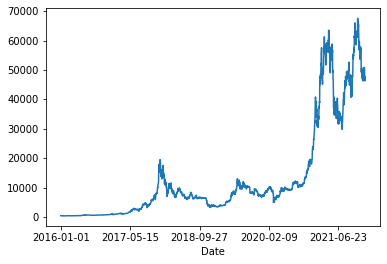

In [113]:
data.Close.plot()

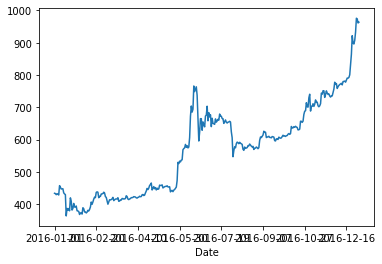

In [114]:
# checking for 1st year
data['2016':'2017'].Close.plot()

### We find that starting of the year, the bitcoin value is low but at the end of the month, value is increased. Lets check if this is a recurring thing

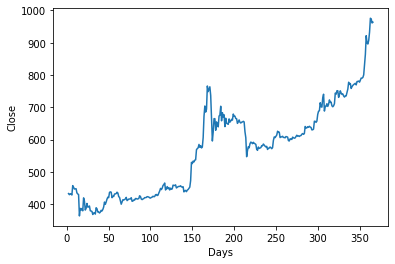

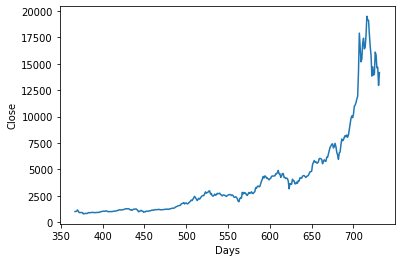

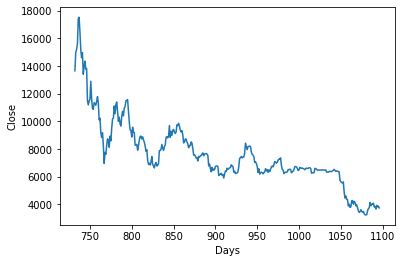

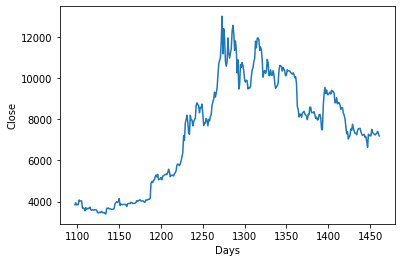

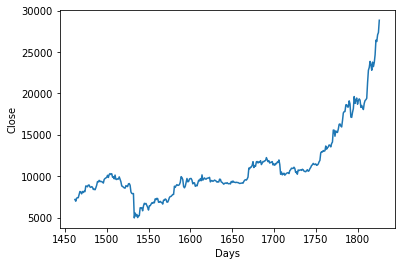

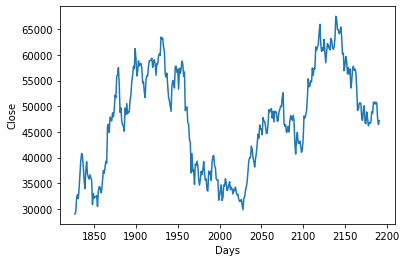

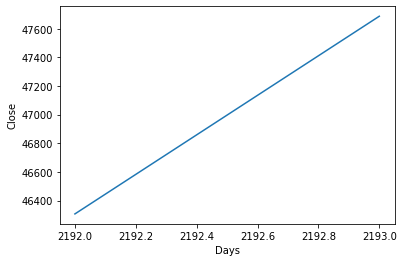

In [115]:
for i in range(1,data.shape[0],365):
    sns.lineplot(x=data.iloc[i:i+365].Days, y=data.iloc[i:i+365].Close)
    plt.show()

### From above, we find that this is somewhat a recurring thing in some of the years (price is low at start of year but increases at the end, but we cannot conclude it

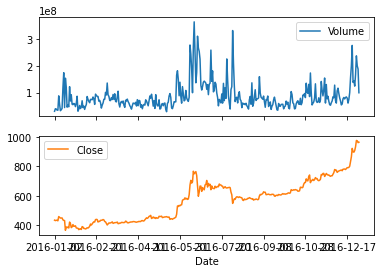

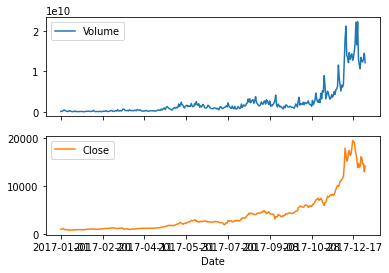

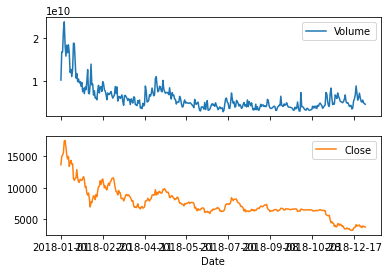

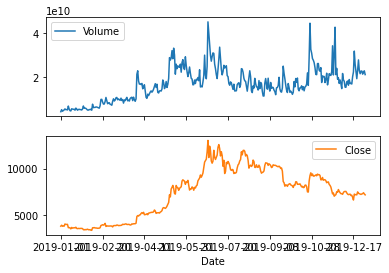

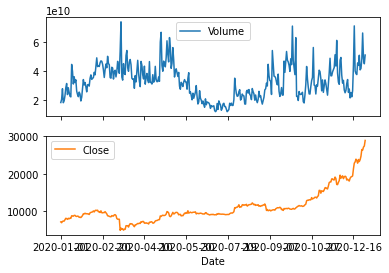

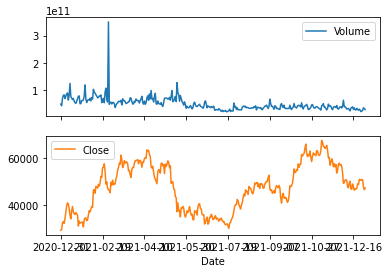

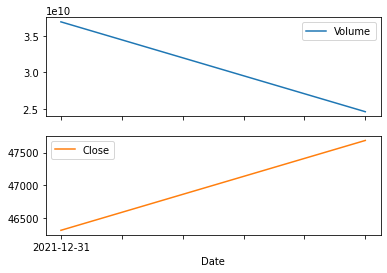

In [116]:
# Checking relationship between Close and volume
for i in range(1,data.shape[0],365):
    data.iloc[i:i+365][['Volume','Close']].plot(subplots=True)
    plt.show()

### We see that with Volume, CLosing price is also varying propotionately

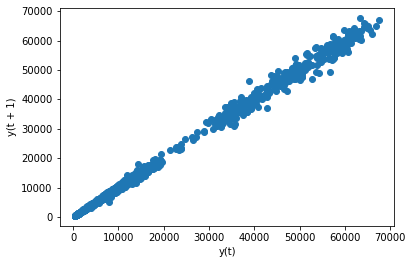

In [117]:
# 1st order Lagplot
pd.plotting.lag_plot(data['Close'],lag=1)
# Linear corralation in lag of 1 day

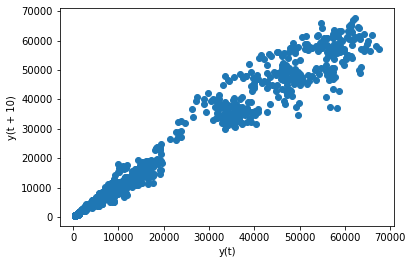

In [118]:
# 10 day Lagplot
pd.plotting.lag_plot(data['Close'],lag=10)
# Not as Linear corralation as in 1 day lag plot in lag of 10 day

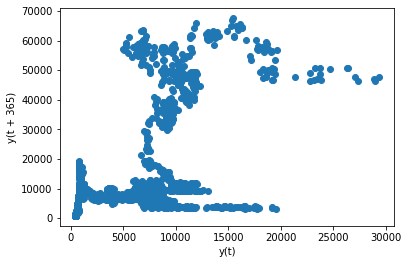

In [119]:
# 1 year Lagplot
pd.plotting.lag_plot(data['Close'],lag=365)
# Not correlated for 1 year

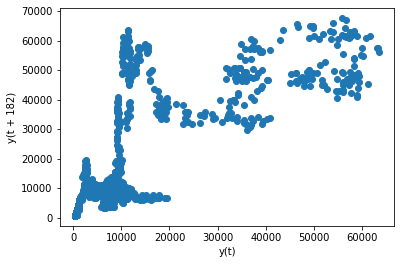

In [120]:
# 6 Months Lagplot
pd.plotting.lag_plot(data['Close'],lag=182)
# Lag plot of 1 year and 6 months is somewhat similar

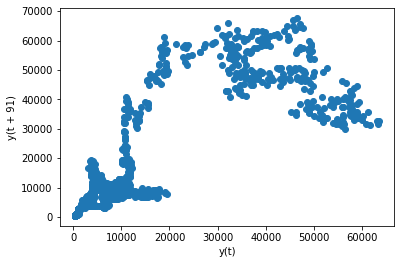

In [121]:
# 3 Months Lagplot
pd.plotting.lag_plot(data['Close'],lag=91)
# Lag plot of 3 months and 6 months is similar

### We can conclude that data is correlated with its previous day data

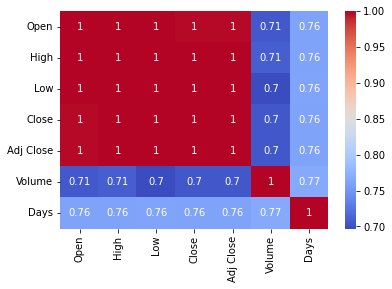

In [122]:
# Checking correalation between data
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

### We see Open, High, low, and Close is having 100% correalation and Volume is having 70% correlation

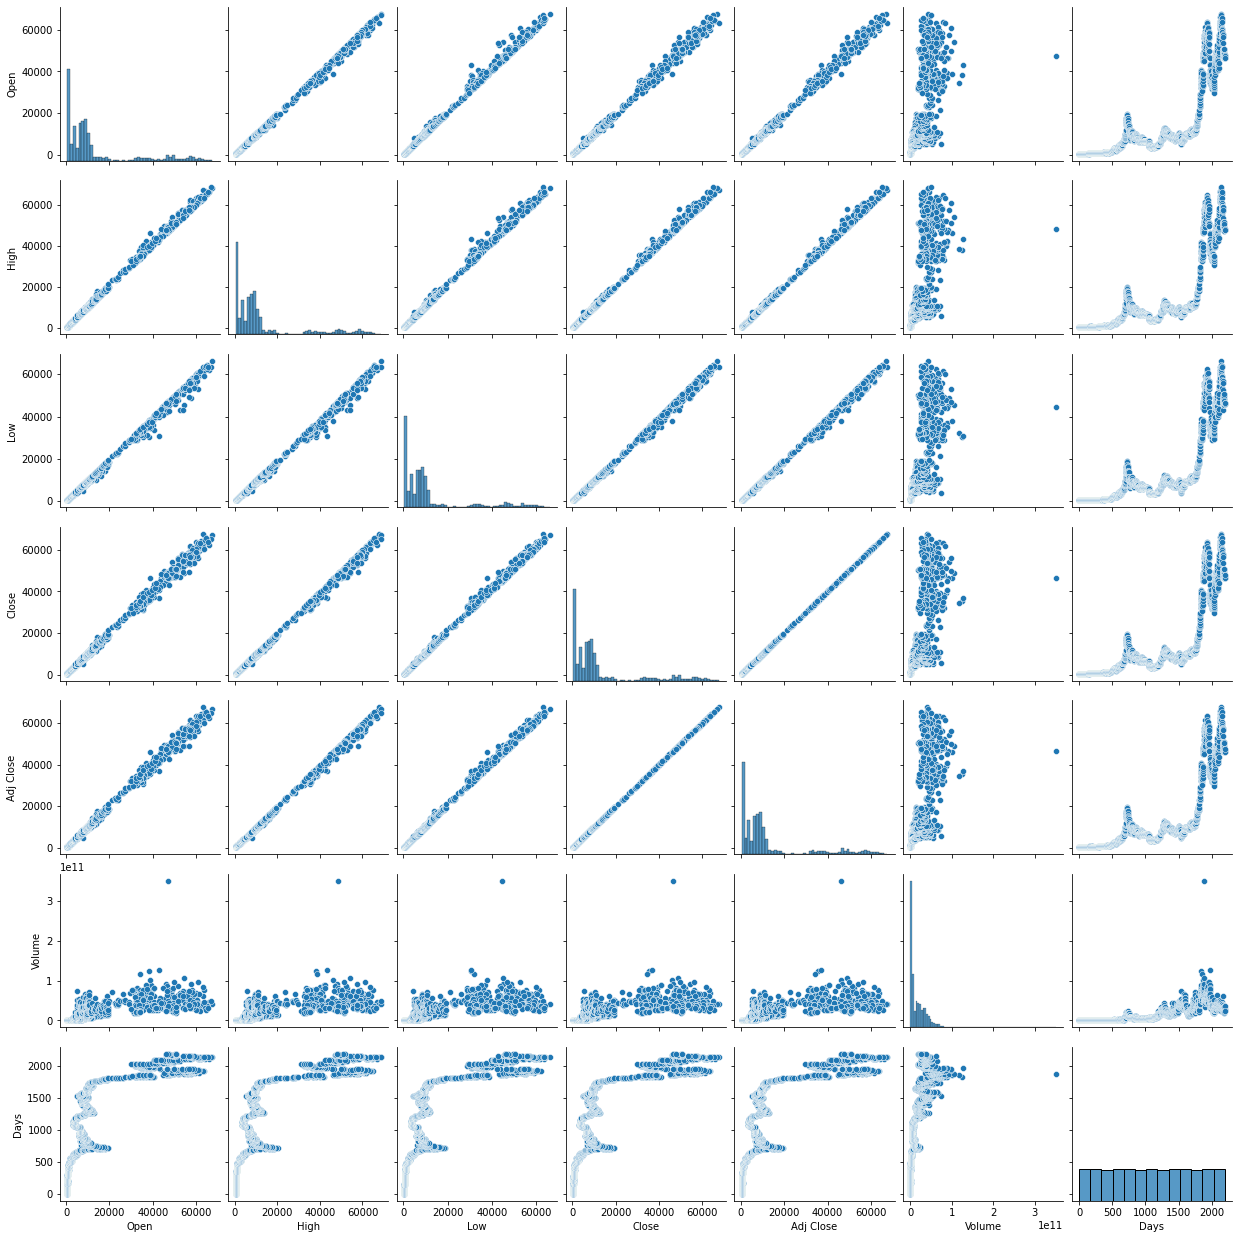

In [123]:
sns.pairplot(data)

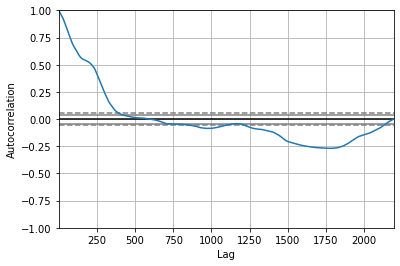

In [124]:
# Drawing autocorrelation plot
pd.plotting.autocorrelation_plot(data.Close)

In [125]:
l = []
for i in range(1,data.shape[0],30):
    l.append(data.Close.iloc[i:i+30].mean())

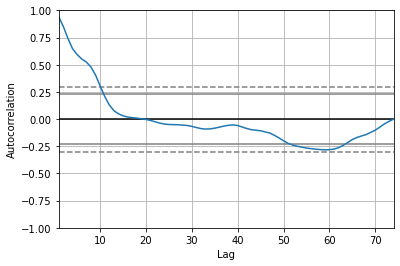

In [126]:
# We see that for lag of 30 days i.e. 1 Month, most of the data lies in 95% CI
pd.plotting.autocorrelation_plot(l)

In [127]:
# KPSS Test
from statsmodels.tsa.stattools import kpss
stats, p, lags, cv = kpss(data.Close,'c')
print('Test Statistic {}, P Value {}, Critical Value {}'.format(stats,p,cv))
if(p<0.05):
    print('data is not stationary')
else:
    print('data is stationary')

Test Statistic 4.582565130170411, P Value 0.01, Critical Value {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
data is not stationary


In [128]:
# ADF Test
adft = adfuller(data.Close)
print("Test stat {}, p value {}, ".format(adft[0],adft[1]))
if(adft[1]>0.05):
    print('data is not stationary')
else:
    print('data is stationary')

Test stat -0.5432579007246372, p value 0.8832950321778041, 
data is not stationary


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

<Figure size 432x288 with 0 Axes>

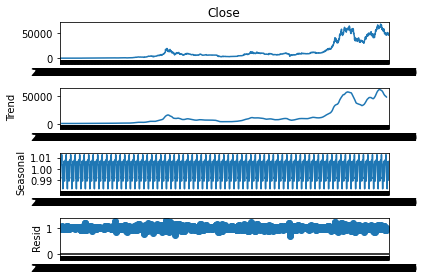

In [129]:
#To separate the trend and the seasonality from the time series
result = seasonal_decompose(data.Close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  

### We can clearly see that there is no seasonality whatsoever and the trend is captured only towards the end

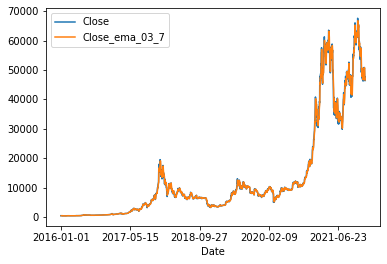

In [130]:
# Implementing exponential smoothing moving average to capture the data more suitably
data['Close_ema_03_7'] = data.Close.ewm(alpha=0.7,adjust=False,min_periods=3).mean().shift(1)
data[['Close','Close_ema_03_7']].plot()

### We can clearly see that with smoothing factor alpha as 0.7 for min period as 3, exponential moving average is able to capture the variations and trends

In [131]:
# Implementing arima as data is not stationary
model = auto_arima(data.Close, m=12, seasonal=False,
                   start_p=0, start_q=0,test='adf', max_order=4,
                   error_action='ignore',suppress_warnings=True,step_wise=True,trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=35732.520, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=35731.854, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=35731.871, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=35731.971, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=35733.852, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=35733.856, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=35735.854, Time=0.42 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=35731.406, Time=0.08 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=35733.399, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=35733.403, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=35731.424, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=35735.400, Time=0.21 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0]          
Total fit time: 1.878 seconds


In [132]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2193
Model:               SARIMAX(1, 1, 0)   Log Likelihood              -17863.703
Date:                Mon, 07 Feb 2022   AIC                          35731.406
Time:                        06:45:28   BIC                          35742.791
Sample:                             0   HQIC                         35735.567
                               - 2193                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0342      0.011     -3.059      0.002      -0.056      -0.012
sigma2      7.019e+05   7010.000    100.132      0.000    6.88e+05    7.16e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             24499.30
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              22.99   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [133]:
train = data.Close
test_data = test.Close

In [134]:
model.fit(train)

ARIMA(order=(1, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [135]:
forecast = model.predict(n_periods=35, return_conf_int=True)

In [136]:
forecast_df = pd.DataFrame(forecast[0], index=test.index, columns=['Prediction'])

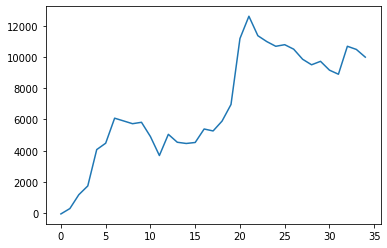

In [137]:
# Plotting the differences, we find that there is a lot of differences between actual and predicted
plt.plot(list(forecast_df.Prediction-test.Close))

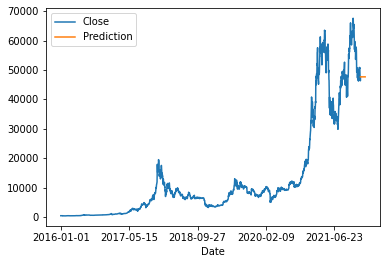

In [138]:
# Predicted plot
pd.concat([data.Close,forecast_df.Prediction],axis=1).plot()

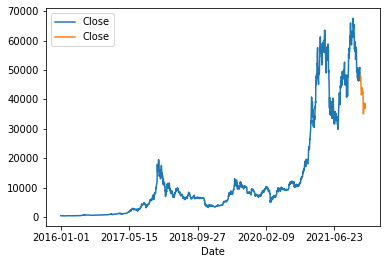

In [197]:
# Actual Plot
pd.concat([data.Close,test.Close],axis=1).plot()

In [215]:
forecast_range = (pd.date_range(start='2022-01-01',end='2022-02-04'))

In [216]:
forecast_range = [str(i).split()[0] for i in forecast_range]

In [221]:
upper = pd.Series(forecast[1][:,0],index=forecast_range)
lower = pd.Series(forecast[1][:,1],index=forecast_range)

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should

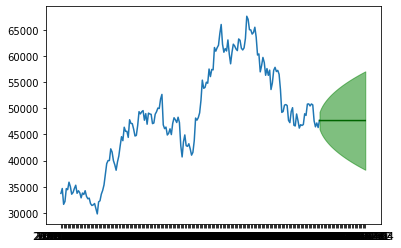

In [230]:
# plotting wrt confidence interval from day number 2000
plt.plot(data.iloc[2000:].Close)
plt.plot(forecast_df, color='darkgreen')
plt.fill_between(forecast_range,lower,upper,color='green',alpha=0.5)

In [140]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(test.Close, forecast_df.Prediction)

6928.17517367743

### MAE for ARIMA is 6928

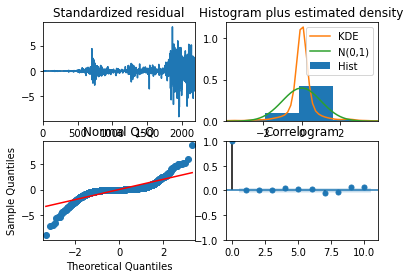

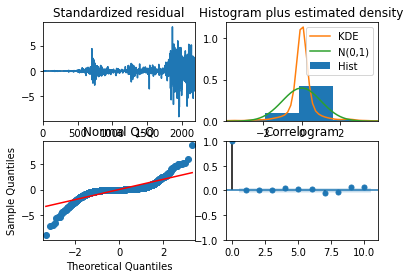

In [141]:
model.plot_diagnostics()

In [142]:
# Implementing Facebook Prophet

In [143]:
data_ds = data.copy(deep=True)
data_ds['ds'] = data_ds.index
data.rename(columns = {'Close':'y'},inplace=True)

In [144]:
data_ds.head()

,Open,High,Low,y,Adj Close,Volume,Days,Close_ema_03_7,ds
Date,,,,,,,,,
2016-01-01,430.721008,436.246002,427.515015,434.334015,434.334015,36278900,1,NaN,2016-01-01
2016-01-02,434.622009,436.062012,431.869995,433.437988,433.437988,30096600,2,NaN,2016-01-02
2016-01-03,433.578003,433.743011,424.705994,430.010986,430.010986,39633800,3,NaN,2016-01-03
2016-01-04,430.061005,434.516998,429.084015,433.091003,433.091003,38477500,4,431.119729,2016-01-04
2016-01-05,433.069000,434.182007,429.675995,431.959991,431.959991,34522600,5,432.499621,2016-01-05


In [145]:
train_data_prophet = data_ds.drop(['Open','High','Low','Adj Close','Volume','Days','Close_ema_03_7'],axis=1)

In [146]:
train_data_prophet.head()

,y,ds
Date,,
2016-01-01,434.334015,2016-01-01
2016-01-02,433.437988,2016-01-02
2016-01-03,430.010986,2016-01-03
2016-01-04,433.091003,2016-01-04
2016-01-05,431.959991,2016-01-05


In [147]:
from fbprophet import Prophet

In [148]:
test.shape[0]

35

In [150]:
# using FB Prophet model
model=Prophet()
model.fit(train_data_prophet)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [151]:
# Creating DF for next 35 days prediction
future_dates=model.make_future_dataframe(periods=35)

In [152]:
future_dates.head()

,ds
0,2016-01-01
1,2016-01-02
2,2016-01-03
3,2016-01-04
4,2016-01-05


In [169]:
prediction=model.predict(future_dates)

In [170]:
prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2223,2022-02-01,65118.411315,59881.141877,72375.519425,65075.112775,65173.280887,1061.306436,1061.306436,1061.306436,-27.124664,-27.124664,-27.124664,1088.431100,1088.431100,1088.431100,0.0,0.0,0.0,66179.717752
2224,2022-02-02,65211.689218,60010.990567,73001.137116,65163.439250,65274.445645,1167.577128,1167.577128,1167.577128,8.942805,8.942805,8.942805,1158.634323,1158.634323,1158.634323,0.0,0.0,0.0,66379.266346
2225,2022-02-03,65304.967121,59904.071468,72603.502075,65249.704428,65372.460492,1211.964550,1211.964550,1211.964550,-37.321672,-37.321672,-37.321672,1249.286222,1249.286222,1249.286222,0.0,0.0,0.0,66516.931671
2226,2022-02-04,65398.245023,60534.168218,73548.653023,65337.832599,65472.670279,1351.394530,1351.394530,1351.394530,-7.746827,-7.746827,-7.746827,1359.141357,1359.141357,1359.141357,0.0,0.0,0.0,66749.639553
2227,2022-02-05,65491.522926,60372.903095,73225.663062,65428.509512,65570.846171,1490.934033,1490.934033,1490.934033,4.403765,4.403765,4.403765,1486.530268,1486.530268,1486.530268,0.0,0.0,0.0,66982.456959


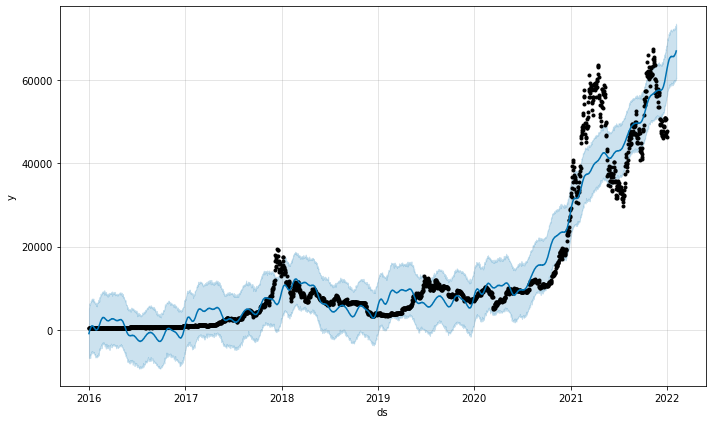

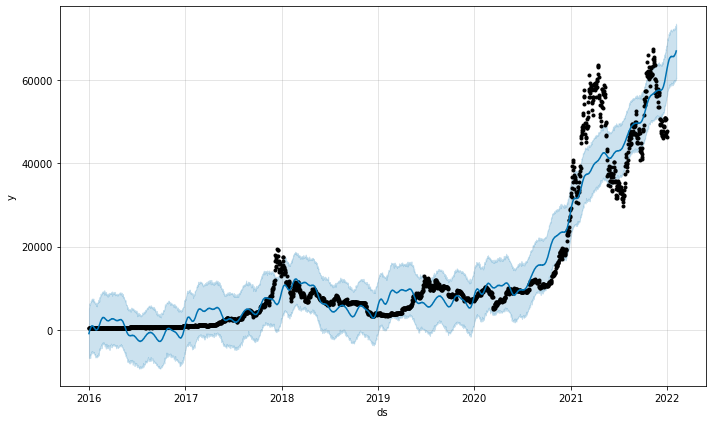

In [171]:
model.plot(prediction)

### The blue line indicates the prediction and the dotted line is the actual. Light blue space is the trend space

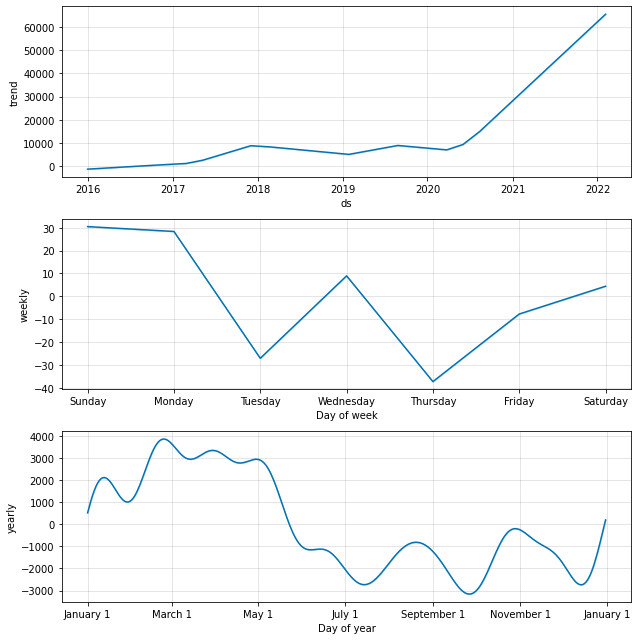

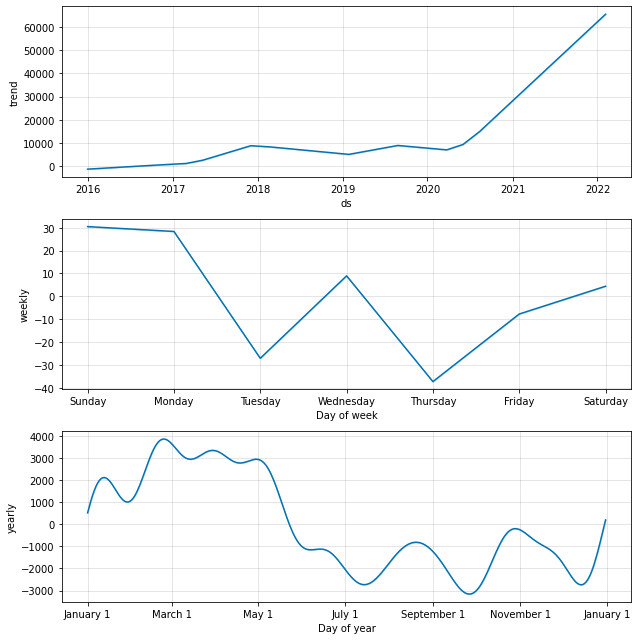

In [156]:
model.plot_components(prediction)

### The trend has exponentially risen from mid of 2020. Before that it was more or less constant

In [157]:
# Finding cross validation error
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet:Making 7 forecasts with cutoffs between 2018-01-17 00:00:00 and 2021-01-01 00:00:00


  0%|          | 0/7 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2018-01-18,14947.132308,14077.697032,15782.631063,11474.900391,2018-01-17
1,2018-01-19,14997.380893,14186.277574,15783.347919,11607.400391,2018-01-17
2,2018-01-20,15057.374192,14174.152006,15850.290310,12899.200195,2018-01-17
3,2018-01-21,15097.038920,14281.530697,15962.823826,11600.099609,2018-01-17
4,2018-01-22,15163.315535,14352.247228,16082.677212,10931.400391,2018-01-17


In [158]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,4.350341e+07,6595.711478,3990.588154,0.284030,0.208431,0.408964
1,38 days,4.591008e+07,6775.698112,4068.915930,0.288249,0.208431,0.411204
2,39 days,4.843107e+07,6959.243565,4157.185005,0.293247,0.211559,0.406723
3,40 days,5.049312e+07,7105.851176,4231.629907,0.297449,0.213113,0.401120
4,41 days,5.286095e+07,7270.553866,4301.090184,0.300739,0.215513,0.394958


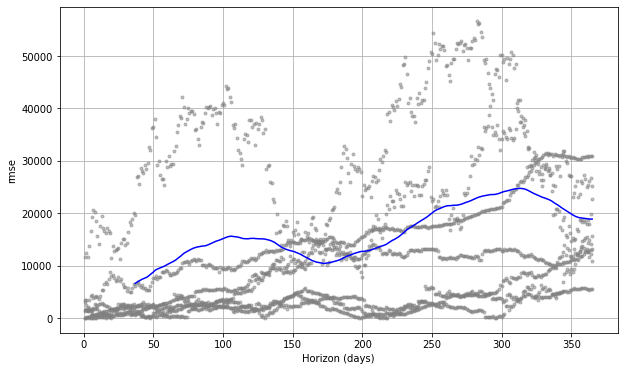

In [172]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='rmse')

In [176]:
prediction.rename(columns = {'ds':'Date'},inplace=True)

In [177]:
prediction = prediction.set_index('Date')

In [178]:
prediction.head()

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
Date,,,,,,,,,,,,,,,,,,
2016-01-01,-1210.456902,-6743.289704,5123.660855,-1210.456902,-1210.456902,318.126601,318.126601,318.126601,-7.746827,-7.746827,-7.746827,325.873428,325.873428,325.873428,0.0,0.0,0.0,-892.330300
2016-01-02,-1204.324964,-6610.080764,5472.985305,-1204.324964,-1204.324964,583.545087,583.545087,583.545087,4.403765,4.403765,4.403765,579.141322,579.141322,579.141322,0.0,0.0,0.0,-620.779877
2016-01-03,-1198.193025,-6760.571857,6403.246830,-1198.193025,-1198.193025,851.819684,851.819684,851.819684,30.487567,30.487567,30.487567,821.332117,821.332117,821.332117,0.0,0.0,0.0,-346.373341
2016-01-04,-1192.061087,-6022.500651,5956.815280,-1192.061087,-1192.061087,1077.670026,1077.670026,1077.670026,28.359026,28.359026,28.359026,1049.311000,1049.311000,1049.311000,0.0,0.0,0.0,-114.391061
2016-01-05,-1185.929149,-6189.023861,6045.864472,-1185.929149,-1185.929149,1233.077200,1233.077200,1233.077200,-27.124664,-27.124664,-27.124664,1260.201864,1260.201864,1260.201864,0.0,0.0,0.0,47.148052


In [188]:
mean_absolute_error(list(prediction.trend.tail(35)),test.Close)

23190.161751484517

### MAE for Prophet is 23190

### Prophet is able to capure trend nicely but Arima has lower MAE

In [231]:
!git remote add --track master upstream git@https://github.com/Fluid-AI/marketprophecy.git
!git fetch upstream

fatal: not a git repository (or any of the parent directories): .git
fatal: not a git repository (or any of the parent directories): .git


In [232]:
!git init
!git add .
!git commit -m "Publishing Solution"

Initialized empty Git repository in /content/.git/

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@ecc96c7aff0b.(none)')
